In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import joblib
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score


# Load your data
dataframe = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/fakelogo detection/file_mapping.csv')

# Map labels
dataframe['Label'] = dataframe['Label'].map({'Genuine': 1, 'Fake': 0})

# Shuffle the DataFrame
dataframe = dataframe.sample(frac=1).reset_index(drop=True)

# Adjust paths for images
base_path = '/content/drive/MyDrive/Colab Notebooks/fakelogo detection'
def adjust_path(path, base_path):
    normalize = path.replace('\\', '/')
    return os.path.join(base_path, normalize.lstrip('/'))

dataframe['adjusted_path'] = dataframe['Filename'].apply(lambda x: adjust_path(x, base_path))
image_paths = dataframe['adjusted_path'].values
labels = dataframe['Label'].values

# First, split into 80% for training and 20% for testing
train_paths, test_paths, train_labels, test_labels = train_test_split(
    image_paths, labels, test_size=0.2, random_state=42)

# Then, split the 20% test set equally into test and validation sets
val_paths, test_paths, val_labels, test_labels = train_test_split(
    test_paths, test_labels, test_size=0.5, random_state=42)


In [ ]:
def preprocess_image(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])
    image = tf.keras.applications.resnet50.preprocess_input(image)
    return image, label

def create_dataset(paths, labels, batch_size=32):
    dataset = tf.data.Dataset.from_tensor_slices((paths, labels))
    dataset = dataset.map(preprocess_image)
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

# Create datasets for training, validation, and testing
train_dataset = create_dataset(train_paths, train_labels)
val_dataset = create_dataset(val_paths, val_labels)
test_dataset = create_dataset(test_paths, test_labels)


Epoch 1/20
21/21 [==============================] - 146s 7s/step - loss: 51.8734 - accuracy: 0.5909 - val_loss: 0.7090 - val_accuracy: 0.4878
Epoch 2/20
21/21 [==============================] - 78s 4s/step - loss: 0.6938 - accuracy: 0.6258 - val_loss: 0.6902 - val_accuracy: 0.6707
Epoch 3/20
21/21 [==============================] - 84s 4s/step - loss: 0.6885 - accuracy: 0.6621 - val_loss: 0.6856 - val_accuracy: 0.6707
Epoch 4/20
21/21 [==============================] - 103s 5s/step - loss: 0.6840 - accuracy: 0.6606 - val_loss: 0.6804 - val_accuracy: 0.6707
Epoch 5/20
21/21 [==============================] - 83s 4s/step - loss: 0.6792 - accuracy: 0.6606 - val_loss: 0.6748 - val_accuracy: 0.6707
Epoch 6/20
21/21 [==============================] - 82s 4s/step - loss: 0.6725 - accuracy: 0.6606 - val_loss: 0.6690 - val_accuracy: 0.6707
Epoch 7/20
21/21 [==============================] - 83s 4s/step - loss: 0.6690 - accuracy: 0.6621 - val_loss: 0.6639 - val_accuracy: 0.6707
Epoch 8/20
21/21 

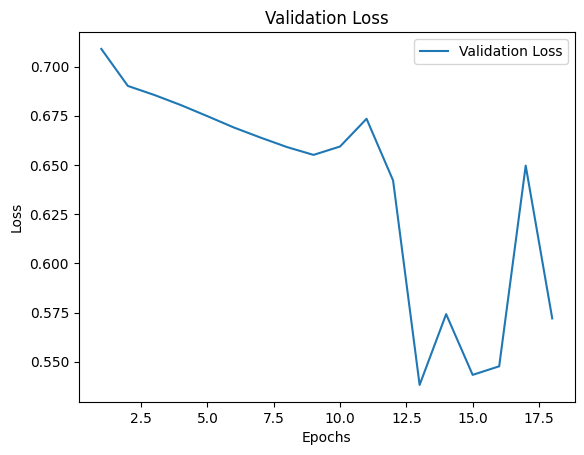

In [ ]:
# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5)
epochs = 20

# Train the model
history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=val_dataset,
    callbacks=[early_stop]
)

# Plot validation loss
val_loss = history.history['val_loss']
epochs_range = range(1, len(val_loss) + 1)
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Save the trained model to disk
model.save('/content/drive/MyDrive/Colab Notebooks/fakelogo detection/saved_model')


In [ ]:
# Define functions for extracting features from a pre-trained CNN model
def extract_features(model, dataset):
    features = []
    labels = []
    for images, labels_batch in dataset:
        features_batch = model.predict(images)
        features.extend(features_batch)
        labels.extend(labels_batch.numpy())
    return np.array(features), np.array(labels)

# Load your trained CNN model
model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/fakelogo detection/saved_model')

# Extract features from the training, validation, and test datasets
train_features, train_labels = extract_features(model, train_dataset)
val_features, val_labels = extract_features(model, val_dataset)
test_features, test_labels = extract_features(model, test_dataset)

# Reshape features for SVM
train_features = train_features.reshape(train_features.shape[0], -1)
val_features = val_features.reshape(val_features.shape[0], -1)
test_features = test_features.reshape(test_features.shape[0], -1)


1/1 [==============================] - 1s 516ms/step


In [ ]:
# Train SVM classifier
svm_classifier = SVC(kernel='linear')  # You can change the kernel as needed
svm_classifier.fit(train_features, train_labels)

# Save the trained SVM classifier to disk
joblib.dump(svm_classifier, '/content/drive/MyDrive/Colab Notebooks/fakelogo detection/svm model/saved_svm_model.pkl')

# Evaluate SVM classifier on validation set
val_predictions = svm_classifier.predict(val_features)
val_accuracy = accuracy_score(val_labels, val_predictions)
print("Validation Accuracy:", val_accuracy)

# Evaluate SVM classifier on test set
test_predictions = svm_classifier.predict(test_features)
test_accuracy = accuracy_score(test_labels, test_predictions)
print("Test Accuracy:", test_accuracy)


Validation Accuracy: 0.9146341463414634
Test Accuracy: 0.8072289156626506


1/1 [==============================] - 0s 79ms/step
Predicted Label: Fake


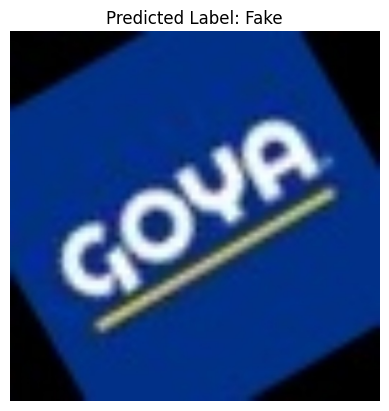

In [ ]:
# Preprocess the input image
import tensorflow as tf
def preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])
    image = tf.keras.applications.resnet50.preprocess_input(image)
    return image

# Extract features from the preprocessed image using the CNN model
def extract_features(model, image):
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    features = model.predict(image)
    return features.reshape(1, -1)  # Reshape for SVM input

# Predict if the image is fake or genuine
def predict_image_label(image_path):
    preprocessed_image = preprocess_image(image_path)
    image_features = extract_features(model, preprocessed_image)
    prediction = svm_classifier.predict(image_features)
    if prediction[0] == 1:
        return 'Genuine'
    else:
        return 'Fake'

# Show the image along with the predicted label
def show_image_with_label(image_path, predicted_label):
    image = plt.imread(image_path)
    plt.imshow(image)
    plt.title("Predicted Label: " + predicted_label)
    plt.axis('off')
    plt.show()

# Example usage: Provide the path to the image in your dataset
image_path = '/content/drive/MyDrive/Colab Notebooks/fakelogo detection/test/Fake/000001_39d298a100044263b4851c6ad5436bcd.jpg'
predicted_label = predict_image_label(image_path)
print("Predicted Label:", predicted_label)
show_image_with_label(image_path, predicted_label)


1/1 [==============================] - 0s 47ms/step


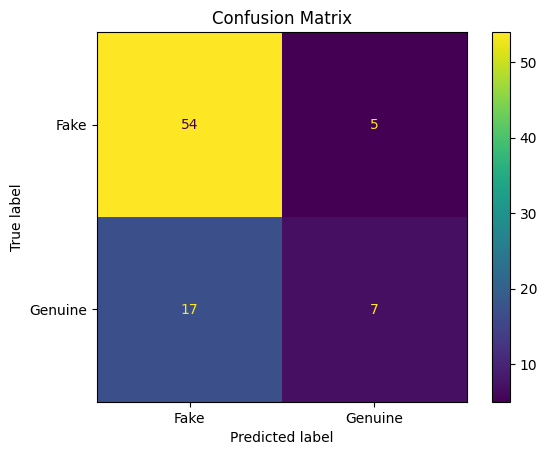

In [ ]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Load the trained model and SVM classifier
model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/fakelogo detection/saved_model')
svm_classifier = joblib.load('/content/drive/MyDrive/Colab Notebooks/fakelogo detection/svm model/saved_svm_model.pkl')

# Preprocess the input image
def preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])
    image = tf.keras.applications.resnet50.preprocess_input(image)
    return image

# Extract features from the preprocessed image using the CNN model
def extract_features(model, image):
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    features = model.predict(image)
    return features.flatten()  # Flatten the features into a 1D array

# Predict if the image is fake or genuine
def predict_image_label(image_path):
    preprocessed_image = preprocess_image(image_path)
    image_features = extract_features(model, preprocessed_image)
    prediction = svm_classifier.predict(image_features.reshape(1, -1))
    if prediction[0] == 1:
        return 'Genuine'
    else:
        return 'Fake'

# Evaluate the model using confusion matrix
def evaluate_model(model, svm_classifier, test_features, test_labels):
    # Predict labels for test features
    test_predictions = svm_classifier.predict(test_features)
    # Create confusion matrix
    cm = confusion_matrix(test_labels, test_predictions)
    # Display confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fake', 'Genuine'])
    disp.plot()
    plt.title('Confusion Matrix')
    plt.show()

# Example usage: Provide the test features and labels
test_features = np.array([extract_features(model, preprocess_image(image_path)) for image_path in test_paths])
test_labels = np.array(test_labels)
evaluate_model(model, svm_classifier, test_features, test_labels)


In [ ]:
# Calculate metrics on the validation set
val_accuracy = accuracy_score(val_labels, val_predictions)
val_precision = precision_score(val_labels, val_predictions)
val_recall = recall_score(val_labels, val_predictions)
val_f1_score = f1_score(val_labels, val_predictions)

print("Validation Accuracy:", val_accuracy)
print("Validation Precision:", val_precision)
print("Validation Recall:", val_recall)
print("Validation F1-score:", val_f1_score)

# Calculate metrics on the test set
test_accuracy = accuracy_score(test_labels, test_predictions)
test_precision = precision_score(test_labels, test_predictions)
test_recall = recall_score(test_labels, test_predictions)
test_f1_score = f1_score(test_labels, test_predictions)

print("Test Accuracy:", test_accuracy)
print("Test Precision:", test_precision)
print("Test Recall:", test_recall)
print("Test F1-score:", test_f1_score)


Validation Accuracy: 0.7560975609756098
Validation Precision: 0.7692307692307693
Validation Recall: 0.37037037037037035
Validation F1-score: 0.5
Test Accuracy: 0.7349397590361446
Test Precision: 0.5833333333333334
Test Recall: 0.2916666666666667
Test F1-score: 0.38888888888888895


In [ ]:
pip install streamlit


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 44.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 42.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.6 MB/s eta 0:00:00


In [ ]:
%%writefile app.py
import streamlit as st
import tensorflow as tf
import numpy as np
from PIL import Image
import joblib

# Load the trained CNN model and SVM classifier
cnn_model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/fakelogo detection/saved_model')
svm_classifier = joblib.load('/content/drive/MyDrive/Colab Notebooks/fakelogo detection/svm model/saved_svm_model.pkl')

# Preprocess the input image
def preprocess_image(image):
    image = image.resize((224, 224))
    image = np.array(image)
    image = tf.keras.applications.resnet50.preprocess_input(image)
    return image

# Extract features from the preprocessed image using the CNN model
def extract_features(model, image):
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    features = model.predict(image)
    return features.flatten()  # Flatten the features into a 1D array

# Predict if the image is fake or genuine
def predict_image_label(image):
    preprocessed_image = preprocess_image(image)
    image_features = extract_features(cnn_model, preprocessed_image)
    prediction = svm_classifier.predict(image_features.reshape(1, -1))
    if prediction[0] == 1:
        return 'Genuine'
    else:
        return 'Fake'

# Streamlit UI
st.title("Fake Logo Detection")

uploaded_file = st.file_uploader("Choose an image...", type=["jpg", "jpeg", "png"])
if uploaded_file is not None:
    image = Image.open(uploaded_file)
    st.image(image, caption='Uploaded Image', use_column_width=True)
    st.write("")
    st.write("Classifying...")

    label = predict_image_label(image)
    st.write(f"The image is classified as: **{label}**")



Overwriting app.py


In [ ]:
!wget -q -O - ipv4.icanhazip.com

35.194.81.110


In [ ]:
! streamlit run app.py & npx localtunnel --port 8501




  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.12:8501
  External URL: http://35.194.81.110:8501

npx: installed 22 in 2.508s
your url is: https://forty-experts-tie.loca.lt
2024-05-19 06:41:50.848943: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-19 06:41:50.848998: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-19 06:41:50.850477: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-19 06:41:52.084259: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
1/1 [====================